### Measure Model Stability after refitting
---

Per MRM request, to determine the extend of data we are allowed to use for refitting (or the other side of the coin of how many months of data needed for validation), let's look at the performance stablity of the newly fitted model.

We will measure the behavior in the following method:
* obtain the old model: `model_old`
* refit a model using partial data: 2019-01-01 - 2020-06-30: `model_v1`
* refit a model using as much data as possible: 2019-01-01 - 2020-11-30: `model_v2`
* segment the labeled data for 2020-12-01 based on `new user`, `existing user` for both models and evaluate on both.

Compare the performance of all three models in the grid-like format

In [1]:
import sys, os, json
sys.path.insert(1, "../../")
from src.combine import combine_data
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import OrderedDict
import src.monitoring.refit as refit
import src.monitoring.governance as gvrn
import src.monitoring.monitoring as mntr
import src.monitoring.utils as mu

%matplotlib inline
plt.style.use('seaborn')

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load modeling_df
dev_path = "../../data/combined_all_features/combined_1616138792.feather"
df = pd.read_feather(dev_path)
df = mu.preprocess(df)

<AxesSubplot:>

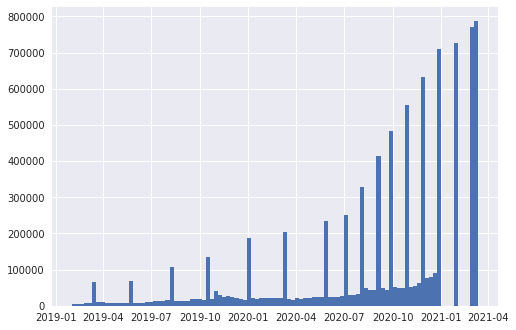

In [3]:
df.sample_date.hist(bins=100)

In [4]:
df.sample_date.max()

Timestamp('2021-03-12 00:00:00')

### Prep Data
---

In [5]:
start = pd.to_datetime("2019-01-01")
end = pd.to_datetime("2019-12-30")
modeling_df_old = df[df.sample_date.between(start, end)]

In [6]:
start = pd.to_datetime("2019-01-01")
end = pd.to_datetime("2020-06-30")  # 6 m
modeling_df_v1 = df[df.sample_date.between(start, end)]

In [7]:
start = pd.to_datetime("2019-01-01")
end = pd.to_datetime("2020-11-30")  # 1 m
modeling_df_v2 = df[df.sample_date.between(start, end)]

In [8]:
valid_df_dec = df[(df.is_static==True) &
              (df.sample_date==pd.to_datetime("2020-12-01"))]
valid_df_mar = df[(df.is_static==True) &
              (df.sample_date==pd.to_datetime("2021-03-01"))]

In [9]:
# stats
modeling_df_old.shape, modeling_df_old.target.value_counts(normalize=True)

((915744, 94),
 False    0.944447
 True     0.055553
 Name: target, dtype: float64)

In [10]:
modeling_df_v1.shape, modeling_df_v1.target.value_counts(normalize=True)

((1992275, 94),
 False    0.958267
 True     0.041733
 Name: target, dtype: float64)

In [11]:
modeling_df_v2.shape, modeling_df_v2.target.value_counts(normalize=True)

((4708572, 94),
 False    0.966713
 True     0.033287
 Name: target, dtype: float64)

In [12]:
# alternative def of defining valid_df_dev to be
# accounts that happened in 2020-dec, before 20210101, to caputure more new accounts
valid_df_dec = df[df.sample_date.between(pd.to_datetime("2020-12-01"),
                                         pd.to_datetime("2020-12-31"))]
valid_df_dec.sort_values(["business_account_number", "sample_date"])
subset = ["business_account_number"] # + old_model.feature_name_
valid_df_dec.drop_duplicates(subset=subset, inplace=True, keep="last")

In [13]:
valid_df_dec.shape, valid_df_mar.shape

((586998, 94), (770065, 94))

### Get the old model
---

In [14]:
prev_model_s3_key = "jxu/money-risk-models/customer-risk-model/models/customer_risk_target_no_giact_time_since_last_link.pkl"
old_model = mu.read_pickle_from_s3("sofi-data-science", prev_model_s3_key)

### Fit the two new models
---

In [15]:
model_v1 = refit.train(modeling_df_v1,
                  date_col="sample_date",
                  indeterminate_col=None)

modeling_df last date: 2020-06-30 00:00:00
15556
target counts
False    1909131
True       83144
Name: target, dtype: int64
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignore

In [16]:
model_v2 = refit.train(modeling_df_v2,
                  date_col="sample_date",
                  indeterminate_col=None)

modeling_df last date: 2020-11-30 00:00:00
15556
target counts
False    4551836
True      156736
Name: target, dtype: int64
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignore

In [17]:
old_model.booster_.save_model("artifacts/model_20191230.txt")
model_v1.booster_.save_model("artifacts/model_20200630.txt")
model_v2.booster_.save_model("artifacts/model_20201130.txt")

### Make Predictions using the 3 models
---

In [18]:
valid_df_dec["pred_20200101"] = old_model.predict_proba(valid_df_dec[old_model.feature_name_])[:,1]
valid_df_dec["score_20200101"] = mu.scale_scores(valid_df_dec["pred_20200101"])

valid_df_dec["pred_20200630"] = model_v1.predict_proba(valid_df_dec[model_v1.feature_name_])[:,1]
valid_df_dec["score_20200630"] = mu.scale_scores(valid_df_dec["pred_20200630"])

valid_df_dec["pred_20201130"] = model_v2.predict_proba(valid_df_dec[model_v2.feature_name_])[:,1]
valid_df_dec["score_20201130"] = mu.scale_scores(valid_df_dec["pred_20201130"])

In [19]:
valid_df_mar["pred_20200101"] = old_model.predict_proba(valid_df_mar[old_model.feature_name_])[:,1]
valid_df_mar["score_20200101"] = mu.scale_scores(valid_df_mar["pred_20200101"])

valid_df_mar["pred_20200630"] = model_v1.predict_proba(valid_df_mar[model_v1.feature_name_])[:,1]
valid_df_mar["score_20200630"] = mu.scale_scores(valid_df_mar["pred_20200630"])

valid_df_mar["pred_20201130"] = model_v2.predict_proba(valid_df_mar[model_v2.feature_name_])[:,1]
valid_df_mar["score_20201130"] = mu.scale_scores(valid_df_mar["pred_20201130"])

### Compare Performances
---

#### On entire population

In [20]:
pred_cols = ["score_20200101", "score_20200630", "score_20201130"]

----- data size -----
(586998, 100)
----- performance report -----


,auc,ap,ks
score_20200101,75.70,18.87,33.60
score_20200630,89.77,35.25,63.98
score_20201130,92.57,43.68,70.34


----- performance plots -----


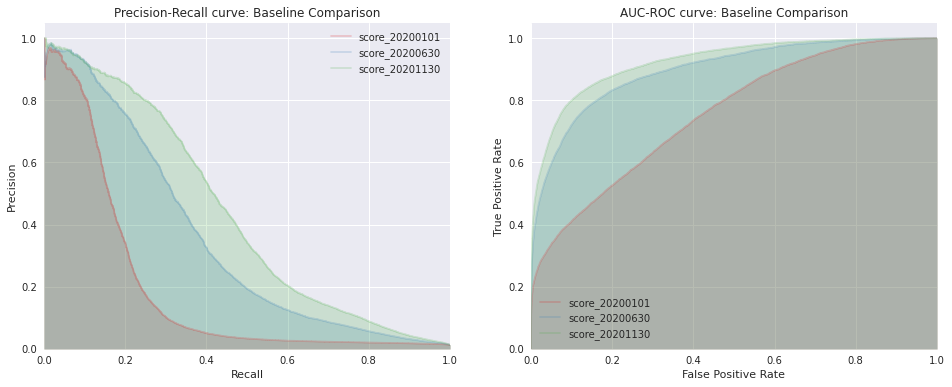

In [21]:
df_ = valid_df_dec
print("----- data size -----")
print(df_.shape)
print("----- performance report -----")
report = mntr.get_pred_reports(df_, "target", pred_cols, dropna=True)
display(report)

print("----- performance plots -----")
mntr.save_valid_performance_plots(
    {"model_stability_exp": df_}, "target", pred_cols, "./artifacts", dropna=False
)

----- data size -----
(770065, 100)
----- performance report -----


,auc,ap,ks
score_20200101,73.07,15.22,31.13
score_20200630,91.46,29.37,69.81
score_20201130,94.93,36.93,77.81


----- performance plots -----


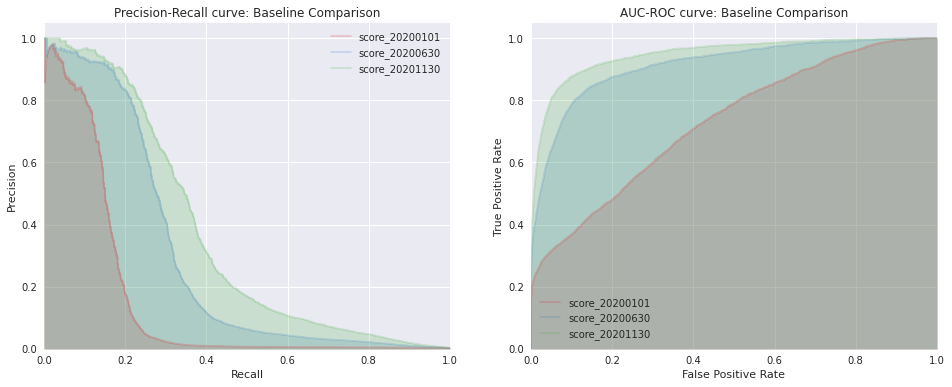

In [22]:
df_ = valid_df_mar
print("----- data size -----")
print(df_.shape)
print("----- performance report -----")
report = mntr.get_pred_reports(df_, "target", pred_cols, dropna=True)
display(report)

print("----- performance plots -----")
mntr.save_valid_performance_plots(
    {"model_stability_exp": df_}, "target", pred_cols, "./artifacts", dropna=False
)

#### On segmented population
---
This begs a question: how do we evaluation or measure stability?
1. observe model performances segmented on `old users` and `new users`
2. observe model performances segmented on `risk groups`?
3. John talked about if we can set a threshold on the predictions and compare results based on the four quadrants of the confusion matrix? I do not know if there is a good way to determine the threshold. Maybe the risk groups would be a good approximation to it. If this is the case, should we use the risk group of the old model for such task as a baseline?

We will only carry out the experiment on December data.

##### 1. Segmented on old/new users

Essentially we have three periods 
1. 20200101 - 20200630
2. 20200701 - 20201130
3. 20201201 - 20201230

3 is the only period that none of the three models have observed.

In [23]:
old_users = df[df.sample_date < pd.to_datetime("2020-11-30")].business_account_number.unique()

df_old_users = valid_df_dec[(valid_df_dec.business_account_number.isin(old_users))]
df_new_users = valid_df_dec[(~valid_df_dec.business_account_number.isin(old_users))]

df_old_users.shape, df_new_users.shape

((515224, 100), (71774, 100))

----- data size -----
(515224, 100)
----- performance report -----


,auc,ap,ks
score_20200101,72.19,15.51,28.47
score_20200630,88.64,31.04,61.10
score_20201130,91.70,38.09,67.58


----- performance plots -----


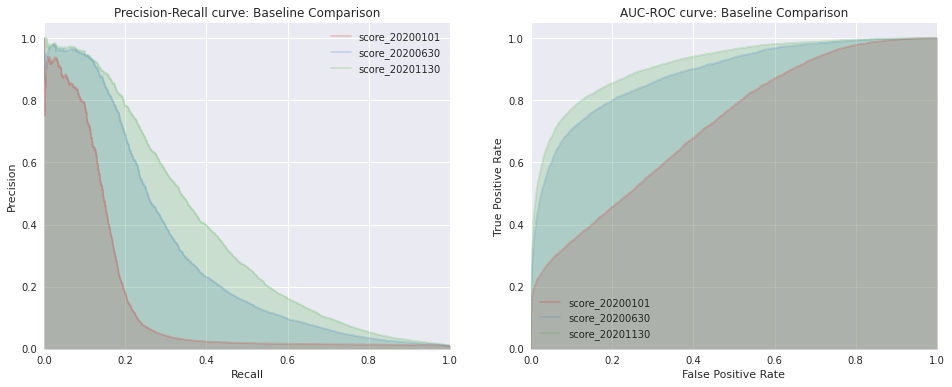

In [33]:
df_ = df_old_users
print("----- data size -----")
print(df_.shape)
print("----- performance report -----")
report = mntr.get_pred_reports(df_, "target", pred_cols, dropna=True)
display(report)

print("----- performance plots -----")
mntr.save_valid_performance_plots(
    {"model_stability_exp": df_}, "target", pred_cols, "./artifacts", dropna=False
)

----- data size -----
(71774, 101)
----- performance report -----


,auc,ap,ks
score_20200101,76.20,25.78,34.93
score_20200630,86.82,42.32,53.36
score_20201130,91.73,53.30,67.55


----- performance plots -----


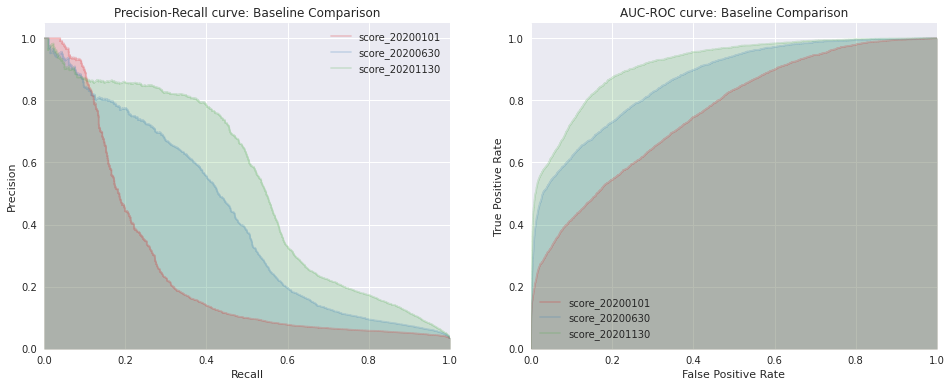

In [34]:
df_ = df_new_users
print("----- data size -----")
print(df_.shape)
print("----- performance report -----")
report = mntr.get_pred_reports(df_, "target", pred_cols, dropna=True)
display(report)

print("----- performance plots -----")
mntr.save_valid_performance_plots(
    {"model_stability_exp": df_}, "target", pred_cols, "./artifacts", dropna=False
)

##### 2. Segment on risk groups
---
In this case it does not make sense to measure segmented performance on the old_model, because the sample is intrinsically biased toward its decisions.

In [35]:
def get_risk_groups(serie):
    return pd.cut(serie.round(), [300, 474, 510, 560, 600, 850], 
                  right=True, labels=[f'RG{i}' for i in range(1, 6)],
                  include_lowest=True)

valid_df_dec["rg_20200101"] = get_risk_groups(valid_df_dec["score_20200101"])
valid_df_dec.rg_20200101.value_counts()

RG5    325702
RG4     86753
RG3     68935
RG1     66473
RG2     39135
Name: rg_20200101, dtype: int64

In [36]:
pred_cols = ["score_20200630", "score_20201130"]

===== RG1 =====
----- data size -----
(66473, 101)
----- performance report -----


,auc,ap,ks
score_20200630,77.49,1.89,49.74
score_20201130,85.61,6.78,58.68


----- performance plots -----
===== RG2 =====
----- data size -----
(39135, 101)
----- performance report -----


,auc,ap,ks
score_20200630,82.62,1.57,50.48
score_20201130,88.89,12.69,66.39


----- performance plots -----
===== RG3 =====
----- data size -----
(68935, 101)
----- performance report -----


,auc,ap,ks
score_20200630,84.51,3.90,55.49
score_20201130,90.49,19.52,68.36


----- performance plots -----
===== RG4 =====
----- data size -----
(86753, 101)
----- performance report -----


,auc,ap,ks
score_20200630,87.04,7.08,60.32
score_20201130,90.88,19.11,66.89


----- performance plots -----
===== RG5 =====
----- data size -----
(325702, 101)
----- performance report -----


,auc,ap,ks
score_20200630,88.42,39.73,62.35
score_20201130,90.94,47.66,68.11


----- performance plots -----


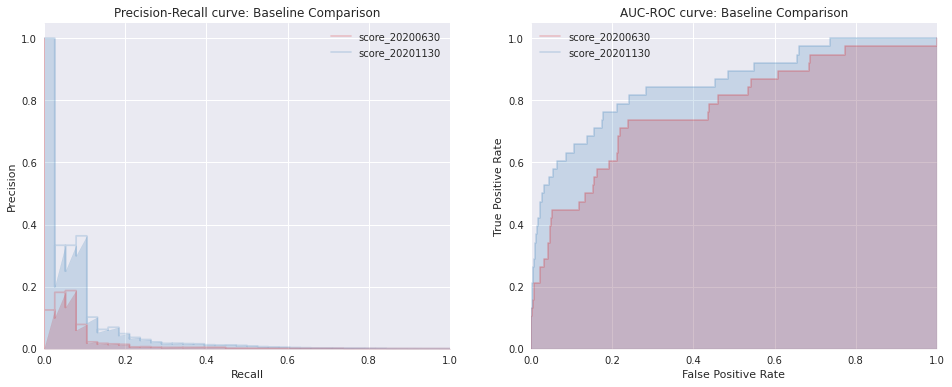

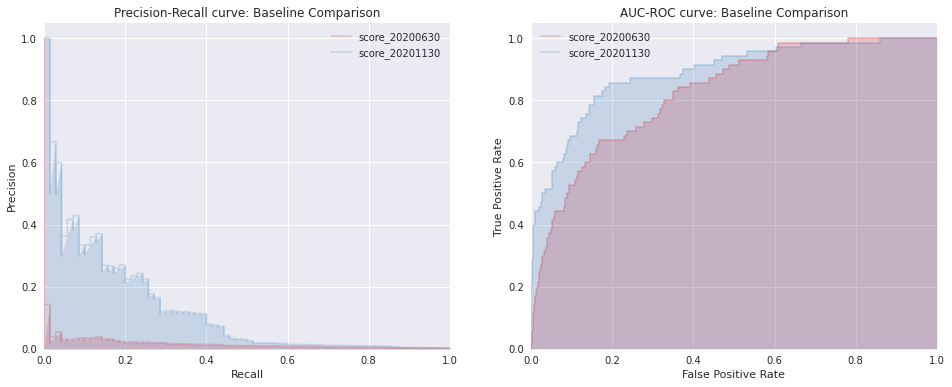

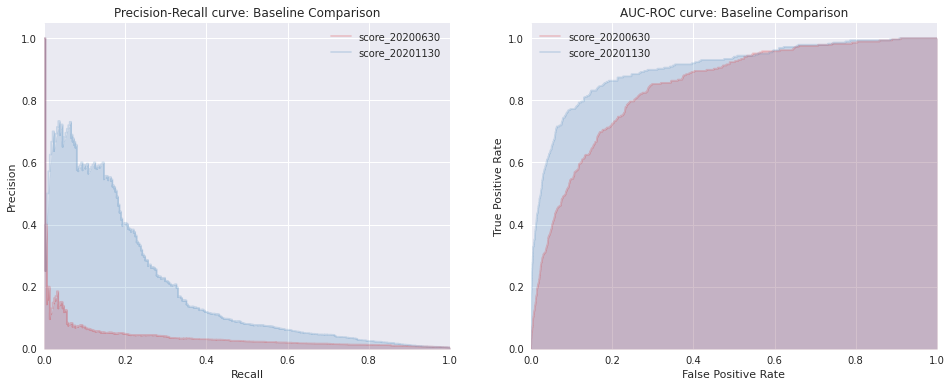

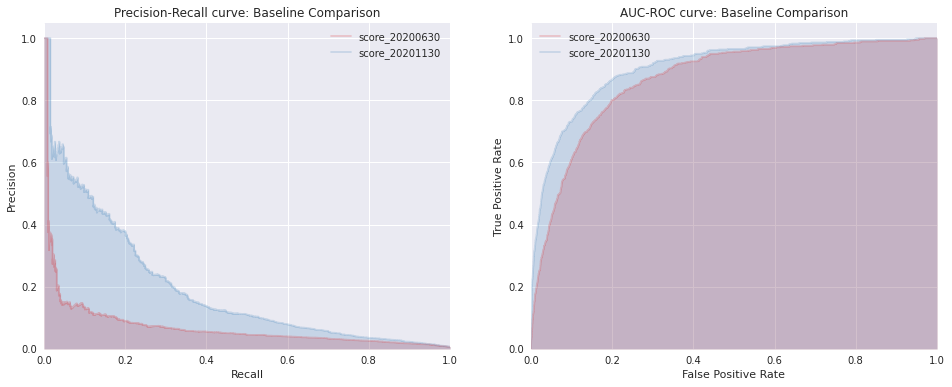

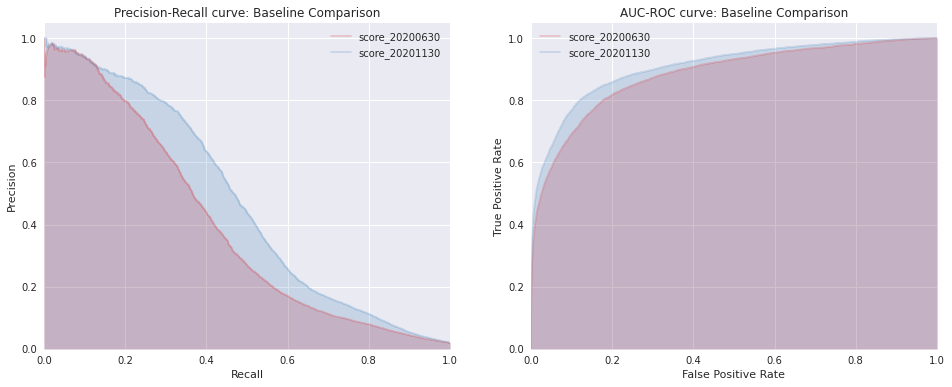

In [37]:
risk_groups = sorted(valid_df_dec.rg_20200101.unique())
for rg_ in risk_groups:
    df_ = valid_df_dec[valid_df_dec.rg_20200101 == rg_]
    print(f"===== {rg_} =====")
    print("----- data size -----")
    print(df_.shape)
    print("----- performance report -----")
    report = mntr.get_pred_reports(df_, "target", pred_cols, dropna=True)
    display(report)

    print("----- performance plots -----")
    mntr.save_valid_performance_plots(
        {"model_stability_exp": df_}, "target", pred_cols, "./artifacts", dropna=False
    )

##### For the new users, what may have caused the model_20211201 to slightout down-perform at the top percentiles

In [38]:
def get_risk_groups(serie):
    return pd.cut(serie.round(), [300, 474, 510, 560, 600, 850], 
                  right=True, labels=[f'RG{i}' for i in range(1, 6)],
                  include_lowest=True)

df_new_users["rg_20200101"] = get_risk_groups(df_new_users["score_20200101"])
df_new_users.rg_20200101.value_counts()

RG5    54915
RG4    10794
RG3     4952
RG2      868
RG1      245
Name: rg_20200101, dtype: int64

===== RG1 =====
----- data size -----
(245, 101) False    245
Name: target, dtype: int64
===== RG2 =====
----- data size -----
(868, 101) False    866
True       2
Name: target, dtype: int64
----- performance report -----


,auc,ap,ks
score_20200630,87.12,2.99,76.44
score_20201130,85.62,3.37,73.09


----- performance plots -----
===== RG3 =====
----- data size -----
(4952, 101) False    4942
True       10
Name: target, dtype: int64
----- performance report -----


,auc,ap,ks
score_20200630,68.26,1.50,47.49
score_20201130,81.17,1.74,54.52


----- performance plots -----
===== RG4 =====
----- data size -----
(10794, 101) False    10727
True        67
Name: target, dtype: int64
----- performance report -----


,auc,ap,ks
score_20200630,92.32,19.70,74.28
score_20201130,94.87,44.48,73.79


----- performance plots -----
===== RG5 =====
----- data size -----
(54915, 101) False    52513
True      2402
Name: target, dtype: int64
----- performance report -----


,auc,ap,ks
score_20200630,84.04,43.25,50.29
score_20201130,90.20,54.03,63.62


----- performance plots -----


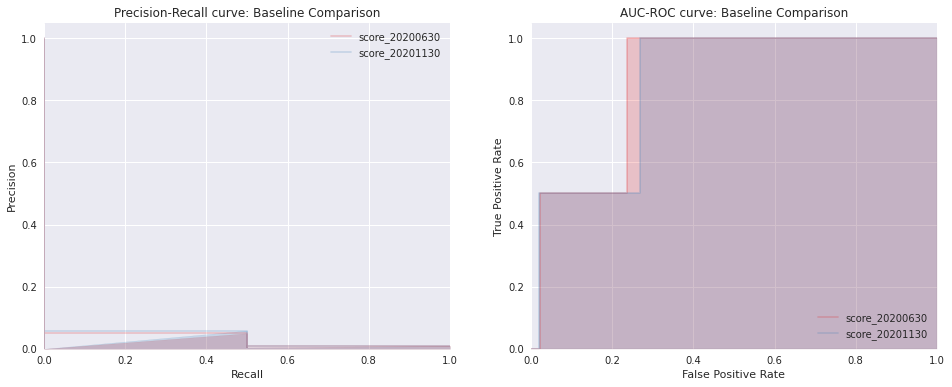

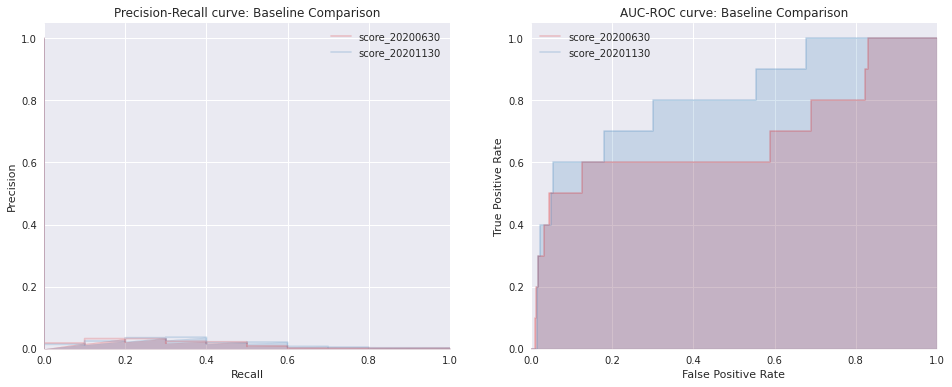

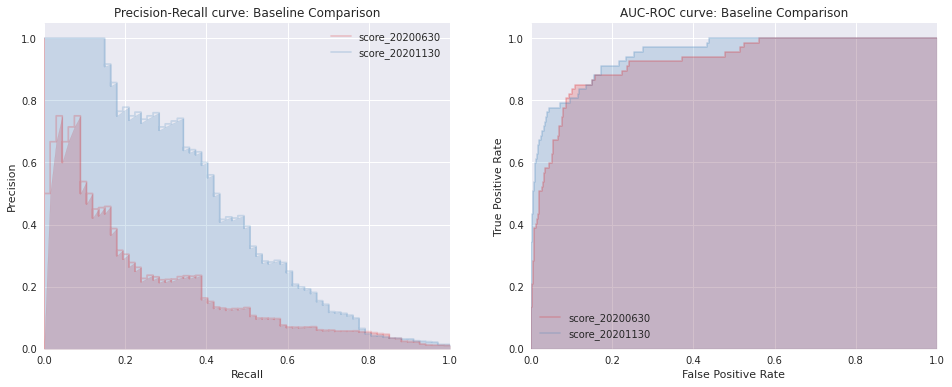

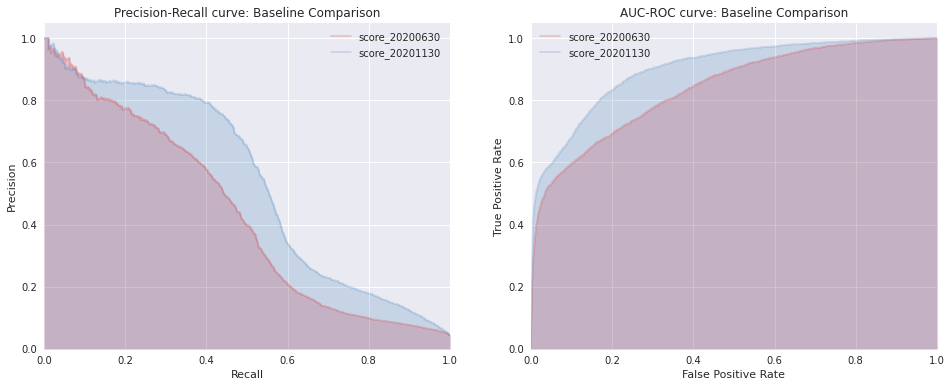

In [39]:
risk_groups = sorted(df_new_users.rg_20200101.unique())
for rg_ in risk_groups:
    df_ = df_new_users[df_new_users.rg_20200101 == rg_]
    print(f"===== {rg_} =====")
    print("----- data size -----")
    print(df_.shape, df_.target.value_counts())
    
    if df_.target.nunique() == 2:
        print("----- performance report -----")
        report = mntr.get_pred_reports(df_, "target", pred_cols, dropna=True)
        display(report)

        print("----- performance plots -----")
        mntr.save_valid_performance_plots(
            {"model_stability_exp": df_}, "target", pred_cols, "./artifacts", dropna=False
        )


##### RG on new users, only Metrics

In [40]:
pred_cols = ["score_20200101", "score_20200630", "score_20201130"]

In [41]:
risk_groups = sorted(valid_df_dec.rg_20200101.unique())
for rg_ in risk_groups:
    df_ = df_new_users[df_new_users.rg_20200101 == rg_]
    print(f"===== {rg_} =====")
    if df_.target.nunique() == 2:
        report = mntr.get_pred_reports(df_, "target", pred_cols, dropna=True)
        display(report)


===== RG1 =====
===== RG2 =====


,auc,ap,ks
score_20200101,48.27,0.39,26.10
score_20200630,87.12,2.99,76.44
score_20201130,85.62,3.37,73.09


===== RG3 =====


,auc,ap,ks
score_20200101,49.39,0.51,12.66
score_20200630,68.26,1.50,47.49
score_20201130,81.17,1.74,54.52


===== RG4 =====


,auc,ap,ks
score_20200101,62.38,1.00,23.25
score_20200630,92.32,19.70,74.28
score_20201130,94.87,44.48,73.79


===== RG5 =====


,auc,ap,ks
score_20200101,71.19,26.49,30.60
score_20200630,84.04,43.25,50.29
score_20201130,90.20,54.03,63.62
